In [3]:
%run ../config/parameters.py
%run ../config/paths.py

In [4]:
import os, random
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge ,LinearRegression, LogisticRegression
from sklearn.model_selection import KFold,StratifiedKFold ,GroupKFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv(P_TRAIN_DATA)
test = pd.read_csv(P_TEST_DATA)
ss = pd.read_csv(P_SAMPLE_SUB)
addition_data = pd.read_csv(P_ADDITIONAL)

train['is_generated'] = 1
test['is_generated'] = 1
addition_data['is_generated'] = 0

addition_data['Attrition'] = (addition_data['Attrition'] == 'Yes').astype(int)
addition_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_generated
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,0
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,80,1,17,3,3,5,2,0,3,0
1466,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,80,1,9,5,3,7,7,1,7,0
1467,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,80,1,6,0,3,6,2,0,3,0
1468,49,0,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,80,0,17,3,2,9,6,0,8,0


In [6]:
train = pd.concat([train, addition_data],axis=0, ignore_index=True)
train = train.drop('EmployeeNumber', axis=1)
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,is_generated
0,0.0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,1,10,2,3,10,0,7,8,0,1
1,1.0,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,1,4,3,3,4,2,0,3,0,1
2,2.0,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,2,4,3,3,3,2,1,2,0,1
3,3.0,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,0,15,1,1,6,0,0,2,0,1
4,4.0,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,0,31,0,3,31,14,4,10,1,1


In [7]:
df = pd.concat([train, test]).reset_index(drop=True)

In [8]:
df.drop(['Over18'],axis =1 ,inplace  = True)

In [9]:
df['MonthlyIncome/Age'] = df['MonthlyIncome'] / df['Age']

df["Age_risk"] = (df["Age"] < 34).astype(int)
df["HourlyRate_risk"] = (df["HourlyRate"] < 60).astype(int)
df["Distance_risk"] = (df["DistanceFromHome"] >= 20).astype(int)
df["YearsAtCo_risk"] = (df["YearsAtCompany"] < 4).astype(int)

df['NumCompaniesWorked'] = df['NumCompaniesWorked'].replace(0, 1)
df['AverageTenure'] = df["TotalWorkingYears"] / df["NumCompaniesWorked"]

df['JobHopper'] = ((df["NumCompaniesWorked"] > 2) & (df["AverageTenure"] < 2.0)).astype(int)

df["AttritionRisk"] = df["Age_risk"] + df["HourlyRate_risk"] + df["Distance_risk"] + df["YearsAtCo_risk"] + df['JobHopper']

In [10]:
data = df.copy()

In [11]:

def SalesDpt(data) :
    if data['Department'] == 'Sales':
        return 1
    else:
        return 0
data['SalesDpt'] = data.apply(lambda data:SalesDpt(data) ,axis = 1)

def JobInvCut(data) :
    if data['JobInvolvement'] < 2.5 :
        return 1
    else:
        return 0
data['JobInvCut'] = data.apply(lambda data:JobInvCut(data) ,axis = 1)

def MiddleTraining(data) :
    if data['TrainingTimesLastYear'] >= 3 and data['TrainingTimesLastYear'] <= 6:
        return 1
    else:
        return 0
data['MiddleTraining'] = data.apply(lambda data:MiddleTraining(data) ,axis = 1)

def MoovingPeople(data) :
    if data['NumCompaniesWorked'] > 4:
        return 1
    else:
        return 0
data['MoovingPeople'] = data.apply(lambda data:MoovingPeople(data), axis = 1)

data['TotalSatisfaction_mean'] = (data['RelationshipSatisfaction']  + data['EnvironmentSatisfaction'] + data['JobSatisfaction'] + data['JobInvolvement'] + data['WorkLifeBalance'])/5

def NotSatif(data) : 
    if  data['TotalSatisfaction_mean'] < 2.35 :
        return 1
    else : 
        return 0
data['NotSatif'] = data.apply(lambda data:NotSatif(data) ,axis = 1)

def LongDisWL1(data) : 
    if  data['DistanceFromHome'] > 11 and data['WorkLifeBalance'] == 1 :
        return 1
    else : 
        return 0
data['LongDisWL1'] = data.apply(lambda data:LongDisWL1(data) ,axis = 1)

def LongDis(data) : 
    if  data['DistanceFromHome'] > 11:
        return 1
    else : 
        return 0
data['LongDis'] = data.apply(lambda data:LongDis(data) ,axis = 1)

def LongDisJobS1(data) : 
    if  data['DistanceFromHome'] > 11 and data['JobSatisfaction'] == 1 :
        return 1
    else : 
        return 0
data['LongDisJobS1'] = data.apply(lambda data:LongDisJobS1(data) ,axis = 1)

def LongDisJL1(data) : 
    if  data['DistanceFromHome'] > 11 and data['JobLevel'] == 1 :
        return 1
    else : 
        return 0
data['LongDisJL1'] = data.apply(lambda data:LongDisJL1(data) ,axis = 1)

def ShortDisNotSingle(data) : 
    if  data['MaritalStatus'] != 'Single' and data['DistanceFromHome'] < 5:
        return 1
    else : 
        return 0
data['ShortDisNotSingle'] = data.apply(lambda data:ShortDisNotSingle(data) ,axis = 1)

def LongDisSingle(data) : 
    if  data['MaritalStatus'] == 'Single' and data['DistanceFromHome'] > 11:
        return 1
    else : 
        return 0
data['LongDisSingle'] = data.apply(lambda data:LongDisSingle(data) ,axis = 1)

def Engaged(data) : 
    if data['Age'] > 35 and data['MaritalStatus'] != 'Single':
        return 1
    else : 
        return 0
data['Engaged'] = data.apply(lambda data:Engaged(data) ,axis = 1)

def YoungAndBadPaid(data) : 
    if data['Age'] < 35 and data['Age'] > 23 and (data['MonthlyIncome'] < 3500):
        return 1
    else : 
        return 0
data['YoungAndBadPaid'] = data.apply(lambda data:YoungAndBadPaid(data) ,axis = 1)

def YoungNeverEngaged(data) : 
    if data['Age'] < 24 and data['MaritalStatus'] == 'Single' :
        return 1
    else : 
        return 0
data['YoungNeverEngaged'] = data.apply(lambda data:YoungNeverEngaged(data) ,axis = 1)

data['Time_in_each_comp'] = (data['Age'] - 20) / ((data)['NumCompaniesWorked'] + 1)
data['RelSatisf_mean'] = (data['RelationshipSatisfaction']  + data['EnvironmentSatisfaction']) / 2
data['JobSatisf_mean'] = (data['JobSatisfaction'] + data['JobInvolvement']) / 2
data['Income_Distance'] = data['MonthlyIncome'] / data['DistanceFromHome']
data['Hrate_Mrate'] = data['HourlyRate'] / data['MonthlyRate']
data['Stability'] = data['YearsInCurrentRole'] / data['YearsAtCompany']
data['Stability'].fillna((data['Stability'].mean()), inplace=True)
data['Income_YearsComp'] = data['MonthlyIncome'] / data['YearsAtCompany']
data['Income_YearsComp'] = data['Income_YearsComp'].replace(np.Inf, 0)
data['Fidelity'] = (data['NumCompaniesWorked']) / data['TotalWorkingYears']
data['Fidelity'] = data['Fidelity'].replace(np.Inf, 0)

In [12]:
data.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,YoungAndBadPaid,YoungNeverEngaged,Time_in_each_comp,RelSatisf_mean,JobSatisf_mean,Income_Distance,Hrate_Mrate,Stability,Income_YearsComp,Fidelity
0,0.0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,0,0,8.0,3.0,3.5,108.166667,0.008237,0.000000,259.600000,0.100000
1,1.0,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,0,0,7.5,2.5,2.0,362.375000,0.004268,0.500000,724.750000,0.250000
2,2.0,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,0,0,6.0,3.5,3.5,177.961538,0.004850,0.666667,1542.333333,0.250000
3,3.0,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,0,0,4.5,3.0,2.0,2673.500000,0.002989,0.000000,891.166667,0.200000
4,4.0,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,0,0,15.0,2.5,2.0,3806.600000,0.001868,0.451613,613.967742,0.032258


In [13]:
df  = data.copy()

In [14]:
# Target Encoding

def encode_ordinal(df, column, target):
    """
    Encodes a categorical column into ordinal values based on the mean of the target variable.
    """
    ordered_labels = df.groupby([column])[target].mean().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    return df[column].map(ordinal_label)

categorical_columns = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus',"OverTime"]

for col in categorical_columns:
    df[f'{col}_ordered'] = encode_ordinal(df, col, 'Attrition')

In [15]:
df=df.select_dtypes(include=np.number)


In [16]:
train = df[:len(train)]
test = df[len(train):]

In [17]:
X = train.drop(columns=['id','Attrition'])
y = train['Attrition']
tes = test.drop(columns=['id','Attrition'])

In [18]:
X.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,Stability,Income_YearsComp,Fidelity,BusinessTravel_ordered,Department_ordered,EducationField_ordered,Gender_ordered,JobRole_ordered,MaritalStatus_ordered,OverTime_ordered
0,36,599,24,3,1,4,42,3,1,4,...,0.000000,259.600000,0.100000,2,0,1,1,6,1,1
1,35,921,8,3,1,1,46,3,1,1,...,0.500000,724.750000,0.250000,1,1,0,1,8,1,0
2,32,718,26,3,1,3,80,3,2,4,...,0.666667,1542.333333,0.250000,1,1,4,1,4,0,0
3,38,1488,2,3,1,3,40,3,2,1,...,0.000000,891.166667,0.200000,1,0,1,0,3,1,0
4,50,1017,5,4,1,2,37,3,5,1,...,0.451613,613.967742,0.032258,1,0,1,0,2,2,1


In [19]:
tes.reset_index(drop=True, inplace=True)

In [20]:
lgb_params = {'num_leaves': 150,
 'max_depth': -1,
 'learning_rate': 0.05,
 'min_split_gain': 0.24664278438096177,
 'min_child_samples': 6,
 'min_child_weight': 0.009893701073314746,
 'subsample': 0.7922433830062748,
 'colsample_bytree': 0.7702871526306962,
 'reg_alpha': 5.989782196924695,
 'reg_lambda': 9.450977321771916,
 'random_state': 42,
 'n_estimators': 5000}
params_CAT_best = {'loss_function': 'Logloss', 
                'eval_metric': 'AUC', 
                'rsm': 0.5992326047662803, 
                'use_best_model': True, 
                'iterations': 928, 
                'learning_rate': 0.08952324786234002, 
                'depth': 4, 
                'l2_leaf_reg': 41.325389866969005, 
                'bootstrap_type': 'Bayesian', 
                'random_strength': 0.00017462745173019666, 
                'bagging_temperature': 2.151687080973658, 
                'od_type': 'Iter', 
                'od_wait': 200}


In [21]:
%%time
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
# import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
import numpy as np
from sklearn.metrics import f1_score,auc,roc_auc_score
from catboost import CatBoostClassifier

# Initialize the model as XGBRegressor with 500 trees
# model = lgb.LGBMClassifier(**lgb_params)
model = CatBoostClassifier()


# Define the number of folds for the KFold cross-validation
n_folds = 10

# Create an instance of KFold with 5 splits, shuffled, and with random_state set to 1235
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1235)

# Create arrays to store the out-of-fold and prediction values
oofs = np.zeros((len(X)))
oofs1 = np.zeros((len(X)))
preds = np.zeros((len(tes)))

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train, eval_set = [(X_test, y_test)],verbose=0, early_stopping_rounds=100)

    # Predict on the validation set
    vp2 = model.predict_proba(X_test)[:,1]
    vp = model.predict_proba(X_test)
    vp1 = (vp[:, 1])

    # Calculate the validation score as the root mean squared error between the true values and predictions
    val_score = roc_auc_score((y_test), (vp1))
    print(f'\nFold {fold+1} Val score: {val_score}\n')

    # Predict on the test set
    tp = model.predict_proba(tes)[:, 1]

    # Store the validation predictions in the oofs array
    oofs[test_index] = vp1
    oofs1[test_index] = vp2
    # Average the predictions over the 5 folds and store in the preds array
    preds += tp/n_folds

# Calculate the out-of-fold score as the root mean squared error between the true values and predictions 0.704879757179547
oof_score = roc_auc_score((y), (oofs))
print(f'\nOOF Accurancy score is : {oof_score}')


Fold 1 Val score: 0.8668232136866822


Fold 2 Val score: 0.9030526668903053


Fold 3 Val score: 0.8102985575310298


Fold 4 Val score: 0.8913955048641395


Fold 5 Val score: 0.7782623280778262


Fold 6 Val score: 0.8454377725595437


Fold 7 Val score: 0.8181818181818181


Fold 8 Val score: 0.8328327469321204


Fold 9 Val score: 0.8564318201321549


Fold 10 Val score: 0.8880116708143825


OOF Accurancy score is : 0.8499033159667981
CPU times: user 16.2 s, sys: 4.57 s, total: 20.8 s
Wall time: 6.15 s


In [22]:
# 0.8266384563303995

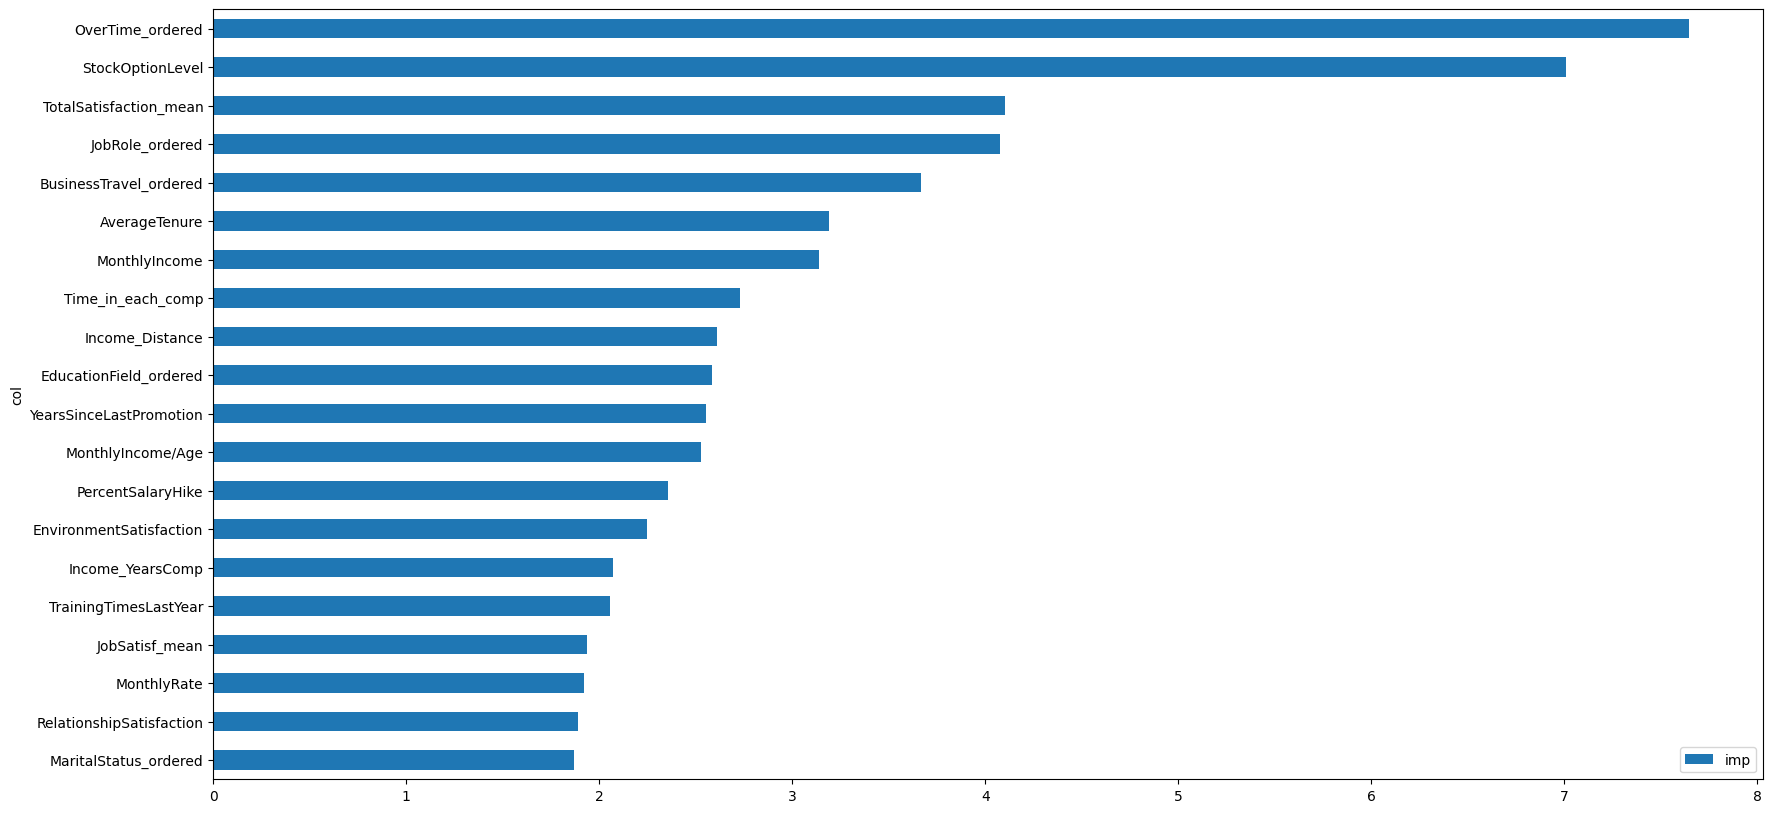

In [23]:
fea_imp = pd.DataFrame({'imp':model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

In [24]:
d = {'id':test['id'], 'Attrition':preds}
submit = pd.DataFrame(d)

In [25]:
submit.id = submit.id.astype(int)

In [26]:
submit.to_csv('cat.csv', index=False)